# FEATURE ENGINEERING & DATA PRE-PROCESSING

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from datetime import date
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

**Importing Datasets**

In [13]:
# Smaller Dataset
def load():
    data = pd.read_csv("titanic.csv")
    return data

In [15]:
# See the shape of smaller dataset
df = load()
print(df.shape)

(891, 12)


In [11]:
# Bigger Dataset
def load_application_train():
    data = pd.read_csv("application_train.csv")
    return data

In [12]:
# See the shape of bigger dataset
df = load_application_train()
print(df.shape)       

(307511, 122)


<p> Let's begin with the Smaller Dataset, "titanic.csv". <br>
We will try to detect outliers in a numerical 'Age' column by using boxplot. </p>

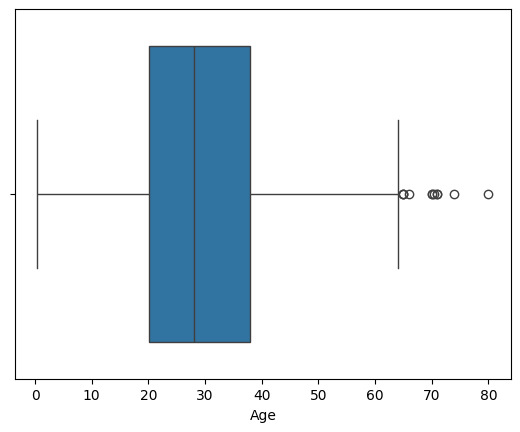

In [17]:
sns.boxplot(x = df["Age"])
plt.show()

<p> Find Q1 (25th percentile) and Q3 (75th percentile), and then minimum and maximum values by using 1.5 IQR. </p>

In [18]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

In [20]:
# Printing Outliers
print(df[(df["Age"] < low) | (df["Age"] > up)])

     PassengerId  Survived  Pclass                                  Name  \
33            34         0       2                 Wheadon, Mr. Edward H   
54            55         0       1        Ostby, Mr. Engelhart Cornelius   
96            97         0       1             Goldschmidt, Mr. George B   
116          117         0       3                  Connors, Mr. Patrick   
280          281         0       3                      Duane, Mr. Frank   
456          457         0       1             Millet, Mr. Francis Davis   
493          494         0       1               Artagaveytia, Mr. Ramon   
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson   
672          673         0       2           Mitchell, Mr. Henry Michael   
745          746         0       1          Crosby, Capt. Edward Gifford   
851          852         0       3                   Svensson, Mr. Johan   

      Sex   Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   male  66.0    

In [21]:
# Index of Outliers
print(df[(df["Age"] < low) | (df["Age"] > up)].index)

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')


In [23]:
# Check if there is a outlier or not using any() function.
print(df[(df["Age"] < low) | (df["Age"] > up)].any(axis = None)) 

True


<p> It returns true because there are some rows that lie beyond the thresholds we specified. Used a parameter called axis = None since we don't care rows or columns. </p>

In [26]:
# Therefore, the below code will return false since there is no outlier that is lower than the threshold.
print(df[(df["Age"] < low)].any(axis = None)) 

False


In [27]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [28]:
print(outlier_thresholds(df, "Age"))

(-6.6875, 64.8125)


<p> As we can see, if age is below -6.68 or higher 64.81, we can say that it is an outlier. But age cannot be lower than 0. So we don't need to care lower threshold since it is -6.68 </p>

In [29]:
low, up = outlier_thresholds(df, "Fare")
print(df[(df["Fare"] < low) | (df["Fare"] > up)].head())

    PassengerId  Survived  Pclass  \
1             2         1       1   
27           28         0       1   
31           32         1       1   
34           35         0       1   
52           53         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
27                     Fortune, Mr. Charles Alexander    male  19.0      3   
31     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
34                            Meyer, Mr. Edgar Joseph    male  28.0      1   
52           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   

    Parch    Ticket      Fare        Cabin Embarked  
1       0  PC 17599   71.2833          C85        C  
27      2     19950  263.0000  C23 C25 C27        S  
31      0  PC 17569  146.5208          B78        C  
34      0  PC 17604   82.1708          NaN        C  
52      0  PC 17572   76.7292         

In [31]:
# Write a function that check if there is any outliers.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

print(check_outlier(df, "Age"))    # True  (yes, there is at least 1 outlier.)
print(check_outlier(df, "Fare"))   # True  (yes, there is at least 1 outlier.)

True
True


In [33]:
# We will try to grab categorical columns, categorical but cardinal columns and numerical columns. 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    '''
    Returns categorical columns list, numerical columns list and categorical but cardinal column list.

    Parameters
    ----------
    dataframe: dataframe
        main dataframe
    cat_th: int, float
        threshold for the number of unique variable of a column that seems numerical but actually categorical
    car_th: int, float
        threshold for the number of unique variable of a column that seems categorical but actually cardinal
    
    Returns
    -------
    cat_cols: list
        list of categorical columns
    num_cols: list
        list of numerical columns
    cat_but_car: list
        list of of cardinal columns
    
    Notes
    ------
    -> cat_cols + num_cols + cat_but_car = the number of columns of dataframe
    -> cat_cols includes num_but_cat
    -> Categorical variables with numerical appearance are also included in categorical variables.

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    '''
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]
print(num_cols) 

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
['Age', 'Fare']


In [34]:
# We will check outliers in numerical columns.
for col in num_cols:
    print(col, check_outlier(df, col))

Age True
Fare True


In [35]:
# Let's import application_train.csv

dff = load_application_train()
cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39


In [36]:
# Although 'SK_ID_CURR' is a numerical column, it is irrelevant for us. Therefore, we will remove it from num_cols

num_cols.remove('SK_ID_CURR')
print()
print()

In [37]:
for col in num_cols:
    print(col, check_outlier(dff, col))

CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI 

In [39]:
# The function below will show us the outlier values for the associated column. If there are outliers more than 10, it will only show us first 5 (f = 5) outliers. Otherwise, it will show all outliers. 

def grab_outliers(dataframe, col_name, outlier_index=False, f = 5):
    low, up = outlier_thresholds(dataframe, col_name)
 
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head(f))
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if outlier_index:
        out_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return out_index
        
age_index = grab_outliers(df, "Age", True)

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  


<p> To Deal With Outliers: We can remove them, or we can change outliers with threshold values. Most of the times, it is better to change outliers with threshold value, because if you remove an outlier and its row, then you loss all other columns of that row. Therefore, it is better to change with threshold value instead of removing them. </p>

In [40]:
df = load()

In [42]:
low, up = outlier_thresholds(df, "Fare")
print(df.shape) # (891, 12)

(891, 12)


In [45]:
# We used tilda (~) in order to see the shape of data without outliers! 
print(df[~((df["Fare"] < low) | (df["Fare"] > up))].shape)

(775, 12)


In [48]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers
    
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [49]:
num_cols.remove('PassengerId')

for col in num_cols:
    df = remove_outlier(df,col)

# Now we removed 'Age' outliers and 'Fare' outliers. Age has 10 outliers and Fare has 116 outliers, therefore we removed 126 outliers. 
print(df.shape)

(765, 12)


In [50]:
# Now we will assign outliers with thresholds. We can write a function for this
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [52]:
df = load()

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [53]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [54]:
num_cols.remove('PassengerId')

In [55]:
# Detecting which column has outliers.

for col in num_cols:
    print(col, check_outlier(df, col))

Age True
Fare True


In [56]:
# Now replace these outliers with thresholds.
for col in num_cols:
    replace_with_thresholds(df, col)

In [57]:
# After replacing, we shouldn't have any outlier. So let's check again.
for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Fare False


**NOTE:** 
Local Outlier Factor (LOF) is a score that tells how likely a certain data point is an outlier/anomaly.

LOF ≈ 1 or -1 ⇒ no outlier <br>
LOF ≫ 1 or ≪ -1 ⇒ outlier


# SYED FAISAL
## KIIT UNIVERSITY
